# Целоусова Полина, группа 5030103-00302

# Домашняя работа на 2023 год

## Описание

Представьте себе, что вы прогуливаетесь по местному рынку под открытым небом... Что вы видите? Что вы чувствуете? Что вы приготовите сегодня на ужин?

Если вы живете в Северной Калифорнии, вы пройдете мимо неизбежных куч листовой зелени, усыпанных темно-фиолетовой капустой и ярко-розовыми и желтыми цветами мангольда. В другой части света, в Южной Корее, вас встретят кучи ярко-красного кимчи, а запах моря привлечет ваше внимание к кальмарам, корчащимся неподалеку. Индийский рынок, пожалуй, самый красочный, он наполнен насыщенными оттенками и ароматами десятков специй: куркумы, аниса, мака, гарам масалы - все, что можно увидеть.

Некоторые из наших самых сильных географических и культурных ассоциаций связаны с местными продуктами питания. В этом задании вам предлагается по списку ингредиентов определить кухню, к которой принадлежит блюдо.

## Данные

В набор данных мы включаем идентификатор рецепта, тип кухни и список ингредиентов каждого рецепта (переменной длины). Данные хранятся в формате JSON.

## Описание файлов

- __data.json__ - обучающий набор, содержащий идентификатор рецепта, тип блюда и список ингредиентов

Пример:

```json
 {
 "id": 24717,
 "cuisine": "indian",
 "ingredients": [
     "tumeric",
     "vegetable stock",
     "tomatoes",
     "garam masala",
     "naan",
     "red lentils",
     "red chili peppers",
     "onions",
     "spinach",
     "sweet potatoes"
 ]
 },
```

## Метрика

В качестве метрики используйте обычную точность - сколько рецептов вы классифицировали правильно.

## Что должно быть в ноутбуке

1. Чтение данных и разбиение на тестовую и обучающую выборку в соотношении 3:7
2. Анализ данных с графиками (например наиболее популярные ингридиенты в каждой кухне)
3. Выбор признаков и их кодирование
4. Анализ признаков
5. Обучение нескольких моделей и подбор гиперпараметров
6. Подсчет метрик
7. Анализ результатов

## Форма сдачи

1. Готовый ноутбук с исследованием
2. Ноутбук нужно показать и ответить на вопросы по нему
3. Сделать форк на гитхабе с данного репозитория и залить ноутбук в эту папку


Импортируем библиотеки

In [77]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from random import shuffle
from random import choice
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [78]:
df = pl.read_json('data.json')
print(df)

shape: (39_774, 3)
┌───────┬─────────────┬───────────────────────────────────┐
│ id    ┆ cuisine     ┆ ingredients                       │
│ ---   ┆ ---         ┆ ---                               │
│ i64   ┆ str         ┆ list[str]                         │
╞═══════╪═════════════╪═══════════════════════════════════╡
│ 10259 ┆ greek       ┆ ["romaine lettuce", "black olive… │
│ 25693 ┆ southern_us ┆ ["plain flour", "ground pepper",… │
│ 20130 ┆ filipino    ┆ ["eggs", "pepper", … "chicken li… │
│ 22213 ┆ indian      ┆ ["water", "vegetable oil", … "sa… │
│ 13162 ┆ indian      ┆ ["black pepper", "shallots", … "… │
│ …     ┆ …           ┆ …                                 │
│ 29109 ┆ irish       ┆ ["light brown sugar", "granulate… │
│ 11462 ┆ italian     ┆ ["KRAFT Zesty Italian Dressing",… │
│ 2238  ┆ irish       ┆ ["eggs", "citrus fruit", … "butt… │
│ 41882 ┆ chinese     ┆ ["boneless chicken skinless thig… │
│ 2362  ┆ mexican     ┆ ["green chile", "jalapeno chilie… │
└───────┴────────────

## Постановка задачи.
$\textbf{Требуется построить модель, которая по списку ингредиентов будет предсказывать, к какой кухне относится данное блюдо.}$

Из ячейки выше видно, что первая колонка имеет тип ```int```, вторая колонка - целевая переменная имеет тип ```str```, третья колонка - ```list[str]```.\
Также датафрейм имеет 39774 строк и 3 столбца.\
Первый столбец - $\textbf{id}$ блюда (не несет никакой информации), вторая колонка - $\textbf{название кухни}$, последняя - $\textbf{список ингредиентов}$, которые используются в рецепте.

В таком виде данных не получится обучить модель, так как для этого нужна матрица. Нужно привести данные к виду матрицы (закодировать их).

## Предложение по кодированию
Закодируем данные следующим образом:
1) Составим список всех уникальных ингредиентов.
2) Создадим новый датафрейм, из значений 0 и 1 по следующему правилу: Для каждой строки (рецепта) в колонке с названием ингредиента будет стоять значение 1, если ингредиент есть в данном рецепте и 0 в противном случае.
3) Объединим исходный dataframe с новым, выкинем колонки ```id``` и ```ingredients```, так как ```id``` не несёт информации, а ```ingredients``` можно будет восстановить по созданным колонкам.


Для начала посмотрим количество кухонь (классов).

In [79]:
print(f"В датафрейме {df['cuisine'].n_unique()} уникальных классов.")

В датафрейме 20 уникальных классов.


$\textbf{Решаем задачу классификации на 20 классов.}$

Получим список уникальных ингредиентов.

In [80]:
all_ingredients = []
for row in df.iter_rows():
    for ingredient_name in row[2]:
        all_ingredients.append(ingredient_name)
all_ingredients[:10]

['romaine lettuce',
 'black olives',
 'grape tomatoes',
 'garlic',
 'pepper',
 'purple onion',
 'seasoning',
 'garbanzo beans',
 'feta cheese crumbles',
 'plain flour']

In [81]:
unique_ingrediets = list(set(all_ingredients))
shuffle(unique_ingrediets)
unique_ingrediets[:10]

['okra',
 'crispy bacon',
 'freshly ground pepper',
 'pheasant',
 'low-fat tartar sauce',
 'pimenton',
 'chocolate shavings',
 'snappers',
 'fresno pepper',
 'prepar pesto']

Получили уникальные ингредиенты с помощью set.\
Посчитаем их количство.

In [82]:
print(f'Всего {len(unique_ingrediets)} уникальных ингредиентов.')

Всего 6714 уникальных ингредиентов.


Создадим пустой Dataframe.

In [83]:
ingredient_df = pl.DataFrame(data=np.zeros((39774, 6714)).astype(int), schema=unique_ingrediets)
print(ingredient_df)

shape: (39_774, 6_714)
┌──────┬──────────────┬────────────────┬──────────┬───┬──────────┬─────────────────┬─────────────┬───────────────┐
│ okra ┆ crispy bacon ┆ freshly ground ┆ pheasant ┆ … ┆ fat free ┆ bread, cut into ┆ cashew milk ┆ bottled chili │
│ ---  ┆ ---          ┆ pepper         ┆ ---      ┆   ┆ whipped  ┆ italian loaf    ┆ ---         ┆ sauce         │
│ i32  ┆ i32          ┆ ---            ┆ i32      ┆   ┆ topping  ┆ ---             ┆ i32         ┆ ---           │
│      ┆              ┆ i32            ┆          ┆   ┆ ---      ┆ i32             ┆             ┆ i32           │
│      ┆              ┆                ┆          ┆   ┆ i32      ┆                 ┆             ┆               │
╞══════╪══════════════╪════════════════╪══════════╪═══╪══════════╪═════════════════╪═════════════╪═══════════════╡
│ 0    ┆ 0            ┆ 0              ┆ 0        ┆ … ┆ 0        ┆ 0               ┆ 0           ┆ 0             │
│ 0    ┆ 0            ┆ 0              ┆ 0        ┆ … ┆ 0

In [84]:
df = pl.concat([df, ingredient_df], how='horizontal')
print(df)

shape: (39_774, 6_717)
┌───────┬─────────────┬─────────────────┬──────┬───┬─────────────────┬─────────────────┬─────────────┬─────────────────┐
│ id    ┆ cuisine     ┆ ingredients     ┆ okra ┆ … ┆ fat free        ┆ bread, cut into ┆ cashew milk ┆ bottled chili   │
│ ---   ┆ ---         ┆ ---             ┆ ---  ┆   ┆ whipped topping ┆ italian loaf    ┆ ---         ┆ sauce           │
│ i64   ┆ str         ┆ list[str]       ┆ i32  ┆   ┆ ---             ┆ ---             ┆ i32         ┆ ---             │
│       ┆             ┆                 ┆      ┆   ┆ i32             ┆ i32             ┆             ┆ i32             │
╞═══════╪═════════════╪═════════════════╪══════╪═══╪═════════════════╪═════════════════╪═════════════╪═════════════════╡
│ 10259 ┆ greek       ┆ ["romaine       ┆ 0    ┆ … ┆ 0               ┆ 0               ┆ 0           ┆ 0               │
│       ┆             ┆ lettuce",       ┆      ┆   ┆                 ┆                 ┆             ┆                 │
│       ┆

In [85]:
for row in range(39774):
    for ingredient_name in df[row, 'ingredients']:
        df[row, ingredient_name] = 1
print(df)

shape: (39_774, 6_717)
┌───────┬─────────────┬─────────────────┬──────┬───┬─────────────────┬─────────────────┬─────────────┬─────────────────┐
│ id    ┆ cuisine     ┆ ingredients     ┆ okra ┆ … ┆ fat free        ┆ bread, cut into ┆ cashew milk ┆ bottled chili   │
│ ---   ┆ ---         ┆ ---             ┆ ---  ┆   ┆ whipped topping ┆ italian loaf    ┆ ---         ┆ sauce           │
│ i64   ┆ str         ┆ list[str]       ┆ i32  ┆   ┆ ---             ┆ ---             ┆ i32         ┆ ---             │
│       ┆             ┆                 ┆      ┆   ┆ i32             ┆ i32             ┆             ┆ i32             │
╞═══════╪═════════════╪═════════════════╪══════╪═══╪═════════════════╪═════════════════╪═════════════╪═════════════════╡
│ 10259 ┆ greek       ┆ ["romaine       ┆ 0    ┆ … ┆ 0               ┆ 0               ┆ 0           ┆ 0               │
│       ┆             ┆ lettuce",       ┆      ┆   ┆                 ┆                 ┆             ┆                 │
│       ┆

Выкинем колонки ```id``` и ```ingredients```.

In [86]:
df = df.drop(['ingredients', 'id'])
print(df)

shape: (39_774, 6_715)
┌─────────────┬──────┬──────────────┬─────────────────┬───┬──────────┬─────────────────┬─────────────┬─────────────────┐
│ cuisine     ┆ okra ┆ crispy bacon ┆ freshly ground  ┆ … ┆ fat free ┆ bread, cut into ┆ cashew milk ┆ bottled chili   │
│ ---         ┆ ---  ┆ ---          ┆ pepper          ┆   ┆ whipped  ┆ italian loaf    ┆ ---         ┆ sauce           │
│ str         ┆ i32  ┆ i32          ┆ ---             ┆   ┆ topping  ┆ ---             ┆ i32         ┆ ---             │
│             ┆      ┆              ┆ i32             ┆   ┆ ---      ┆ i32             ┆             ┆ i32             │
│             ┆      ┆              ┆                 ┆   ┆ i32      ┆                 ┆             ┆                 │
╞═════════════╪══════╪══════════════╪═════════════════╪═══╪══════════╪═════════════════╪═════════════╪═════════════════╡
│ greek       ┆ 0    ┆ 0            ┆ 0               ┆ … ┆ 0        ┆ 0               ┆ 0           ┆ 0               │
│ souther

Как мы и хотели, получилась матрица с помощью которой можно обучить модель машинного обучения.

## Исследование данных

Для начала посмотрим распределение столбца ```cuisine```.

In [87]:
cuisine_counts = df['cuisine'].value_counts().sort('count', descending=True)
print(cuisine_counts)

shape: (20, 2)
┌─────────────┬───────┐
│ cuisine     ┆ count │
│ ---         ┆ ---   │
│ str         ┆ u32   │
╞═════════════╪═══════╡
│ italian     ┆ 7838  │
│ mexican     ┆ 6438  │
│ southern_us ┆ 4320  │
│ indian      ┆ 3003  │
│ chinese     ┆ 2673  │
│ …           ┆ …     │
│ filipino    ┆ 755   │
│ irish       ┆ 667   │
│ jamaican    ┆ 526   │
│ russian     ┆ 489   │
│ brazilian   ┆ 467   │
└─────────────┴───────┘


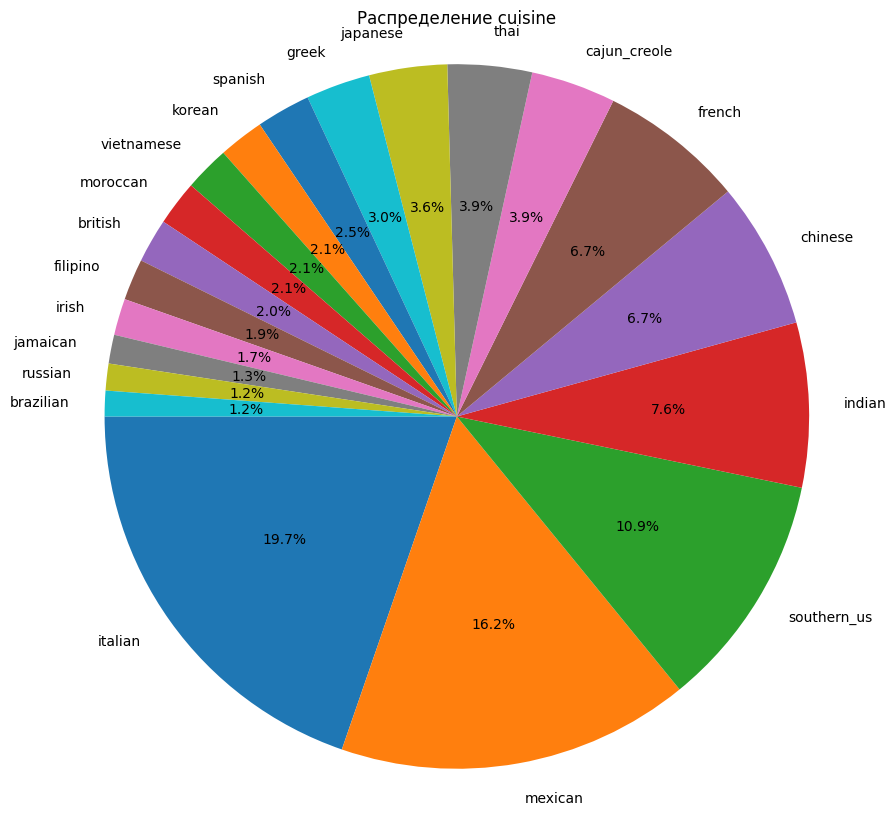

In [88]:
plt.figure(figsize=(10, 10))
labels = cuisine_counts['cuisine']
values = cuisine_counts['count']
plt.title('A Pie Chart')
plt.pie(values,labels=labels, autopct='%1.1f%%', startangle=180)
plt.axis('equal')
plt.title('Распределение cuisine')
plt.show()

$\textbf{Распределение таргета отличается от равномерного.}$

Также построим график самых популярных ингредиентов.

In [89]:
ingredient_counts = df.drop('cuisine').sum()
print(ingredient_counts)

shape: (1, 6_714)
┌──────┬──────────────┬────────────────┬──────────┬───┬──────────┬─────────────────┬─────────────┬───────────────┐
│ okra ┆ crispy bacon ┆ freshly ground ┆ pheasant ┆ … ┆ fat free ┆ bread, cut into ┆ cashew milk ┆ bottled chili │
│ ---  ┆ ---          ┆ pepper         ┆ ---      ┆   ┆ whipped  ┆ italian loaf    ┆ ---         ┆ sauce         │
│ i32  ┆ i32          ┆ ---            ┆ i32      ┆   ┆ topping  ┆ ---             ┆ i32         ┆ ---           │
│      ┆              ┆ i32            ┆          ┆   ┆ ---      ┆ i32             ┆             ┆ i32           │
│      ┆              ┆                ┆          ┆   ┆ i32      ┆                 ┆             ┆               │
╞══════╪══════════════╪════════════════╪══════════╪═══╪══════════╪═════════════════╪═════════════╪═══════════════╡
│ 268  ┆ 2            ┆ 949            ┆ 3        ┆ … ┆ 1        ┆ 8               ┆ 1           ┆ 2             │
└──────┴──────────────┴────────────────┴──────────┴───┴───────

In [90]:
labels = ingredient_counts.columns
values = ingredient_counts.to_numpy().ravel()
ingredient_df = pl.DataFrame({'ingredient_name': labels,
                             'count': values})
print(ingredient_df)

shape: (6_714, 2)
┌──────────────────────────────┬───────┐
│ ingredient_name              ┆ count │
│ ---                          ┆ ---   │
│ str                          ┆ i32   │
╞══════════════════════════════╪═══════╡
│ okra                         ┆ 268   │
│ crispy bacon                 ┆ 2     │
│ freshly ground pepper        ┆ 949   │
│ pheasant                     ┆ 3     │
│ low-fat tartar sauce         ┆ 1     │
│ …                            ┆ …     │
│ parsley leaves               ┆ 60    │
│ fat free whipped topping     ┆ 1     │
│ bread, cut into italian loaf ┆ 8     │
│ cashew milk                  ┆ 1     │
│ bottled chili sauce          ┆ 2     │
└──────────────────────────────┴───────┘


In [91]:
ingredient_df = ingredient_df.sort('count', descending=True)
print(ingredient_df)

shape: (6_714, 2)
┌──────────────────────────┬───────┐
│ ingredient_name          ┆ count │
│ ---                      ┆ ---   │
│ str                      ┆ i32   │
╞══════════════════════════╪═══════╡
│ salt                     ┆ 18048 │
│ onions                   ┆ 7972  │
│ olive oil                ┆ 7971  │
│ water                    ┆ 7457  │
│ garlic                   ┆ 7380  │
│ …                        ┆ …     │
│ bourbon liqueur          ┆ 1     │
│ skinless chicken fillets ┆ 1     │
│ clam sauce               ┆ 1     │
│ fat free whipped topping ┆ 1     │
│ cashew milk              ┆ 1     │
└──────────────────────────┴───────┘


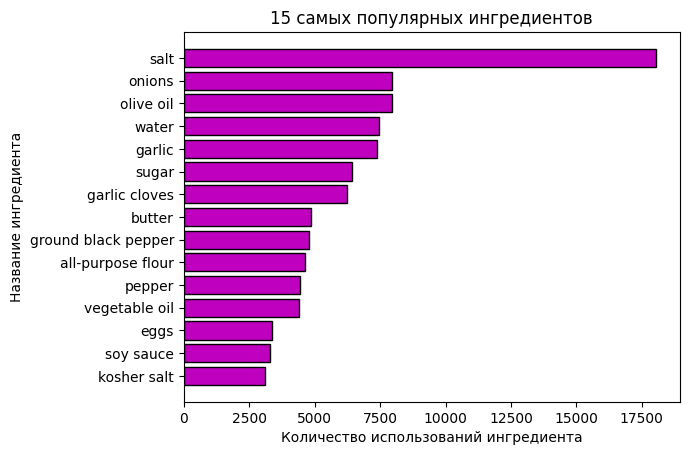

In [92]:
labels = list(ingredient_df['ingredient_name'])[:15]
counts = list(ingredient_df['count'])[:15]
plt.barh(list(reversed(labels)), list(reversed(counts)), color='m', edgecolor='black')
plt.xlabel('Количество использований ингредиента')
plt.ylabel('Название ингредиента')
plt.title('15 самых популярных ингредиентов')
plt.show()

Для того, чтобы получить самые популярные ингредиенты для каждой кухни, нужно повторить манипуляции, описанные выше только с условием филтрации на кухни.\
Для удобства реализуем функцию.

In [93]:
def plot_most_popular_ingredients_barh(data: pl.DataFrame, cuisine_name) -> None:
    """
    :param data: Преобразованный dataframe
    :param cuisine_name: Название кухни
    :return: строит столбчатую диаграмму самых популярных ингредиентов в кухне
    """
    cuisine_dict = {'russian': 'русской',
     'mexican': 'мексиканской',
     'southern_us': 'южно-американской',
     'italian': 'итальяской',
     'filipino': 'филлипинской',
     'thai': 'тайской',
     'moroccan': 'марокканской',
     'greek': 'греческой',
     'spanish': 'испанской',
     'vietnamese': 'вьетнамской',
     'brazilian': 'бразильской',
     'chinese': 'китайской',
     'jamaican': 'ямайской',
     'japanese': 'японской',
     'irish': 'ирландской',
     'cajun_creole': 'креольской',
     'korean': 'корейской',
     'french': 'французской',
     'indian': 'индийской',
     'british': 'британской'}
    random_colors = ['b', 'g', 'r', 'c', 'm']
    data = data.filter(pl.col('cuisine') == cuisine_name)
    data = data.drop('cuisine').sum()
    labels = data.columns
    values = data.to_numpy().ravel()
    data = pl.DataFrame({'ingredient_name': labels,
                             'count': values})
    data = data.sort('count', descending=True)
    labels = list(data['ingredient_name'])[:15]
    counts = list(data['count'])[:15]
    plt.barh(list(reversed(labels)), list(reversed(counts)), color=choice(random_colors), edgecolor='black')
    plt.xlabel('Количество использований ингредиента')
    plt.ylabel('Название ингредиента')
    plt.title(f'15 самых популярных ингредиентов в {cuisine_dict[cuisine_name]} кухне')
    plt.show()

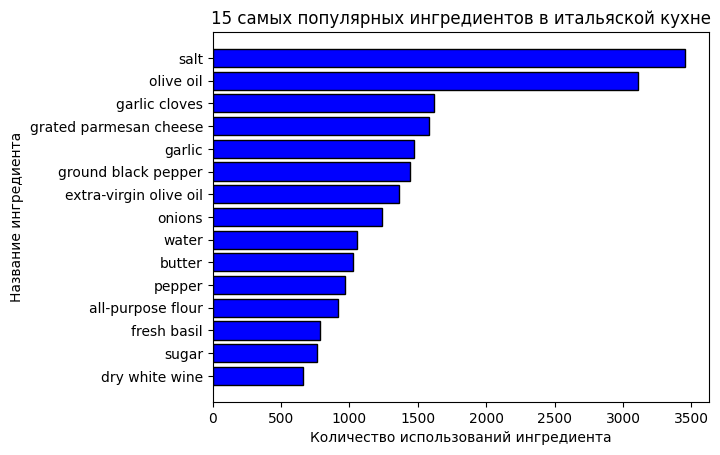

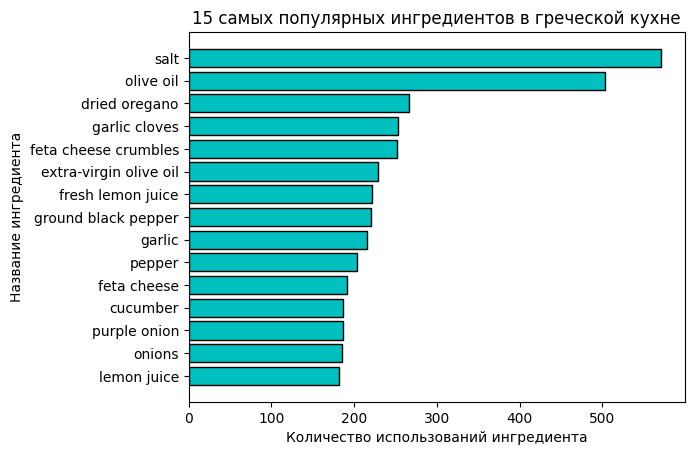

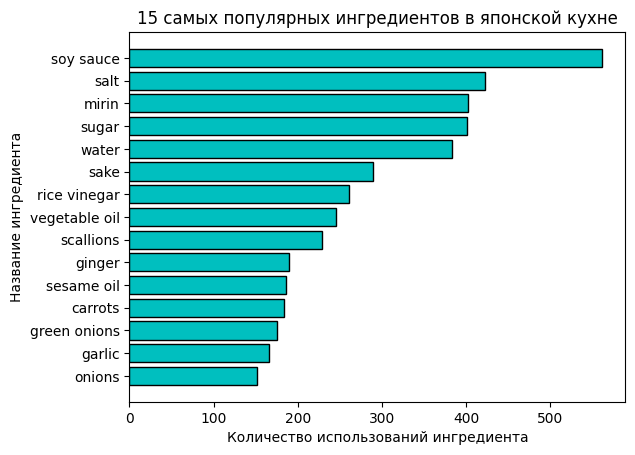

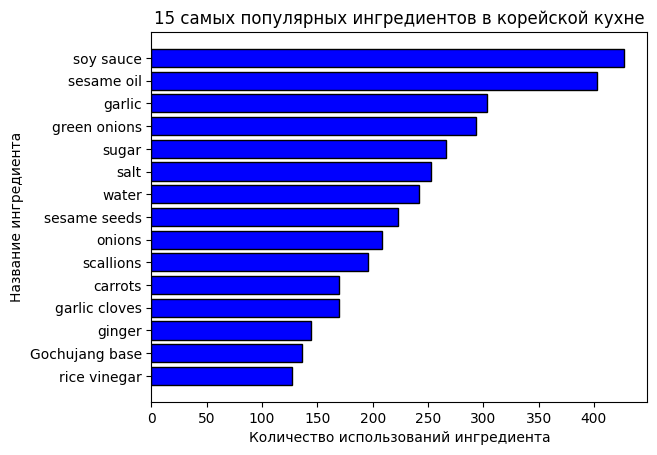

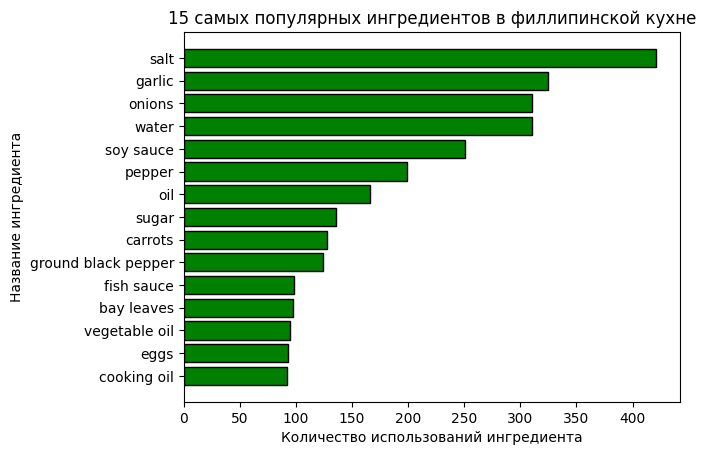

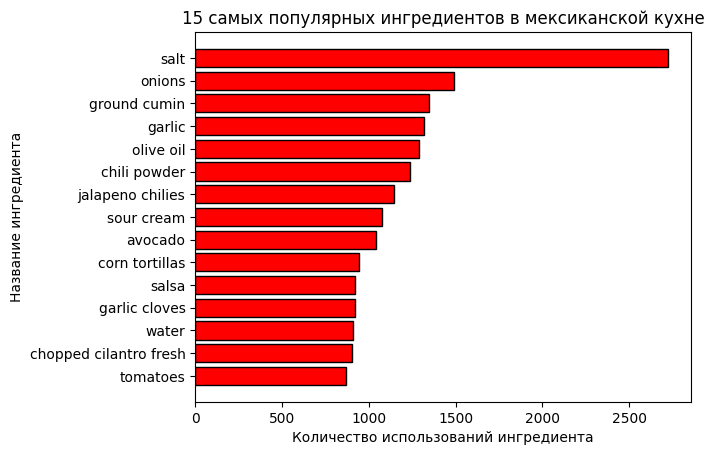

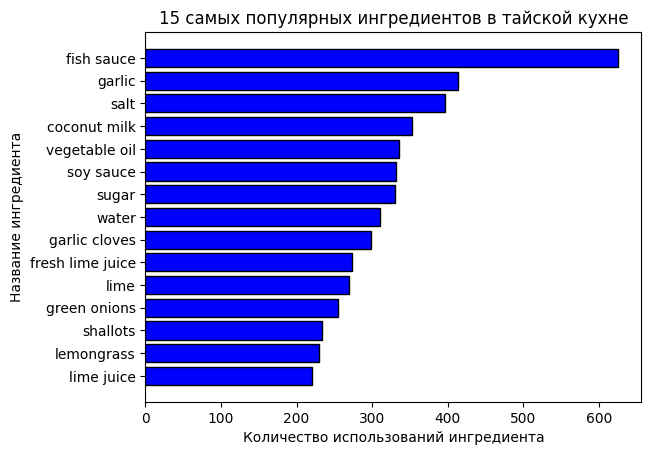

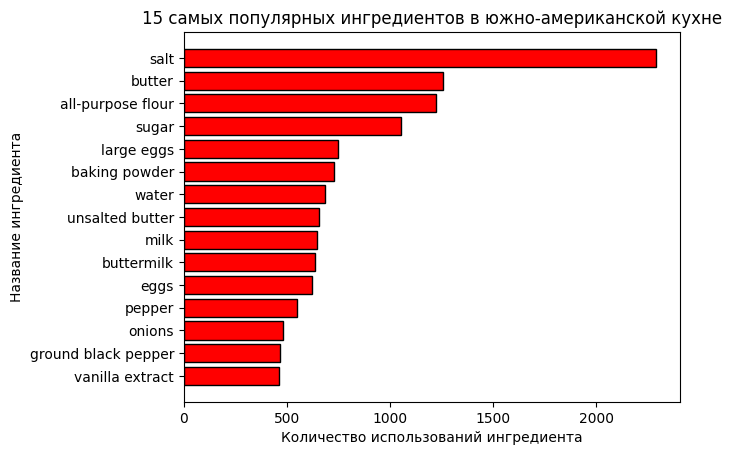

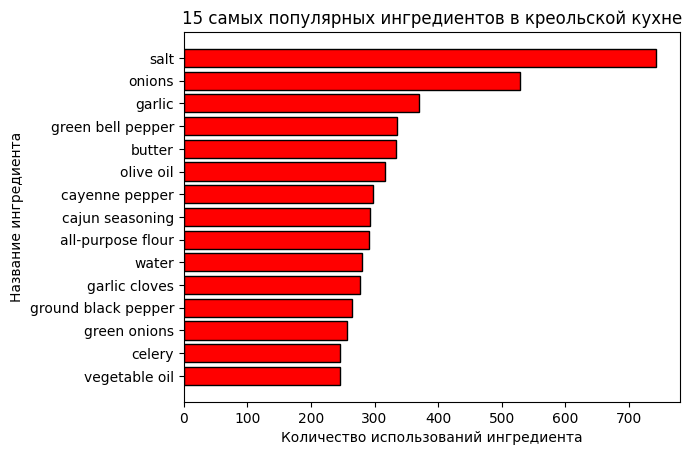

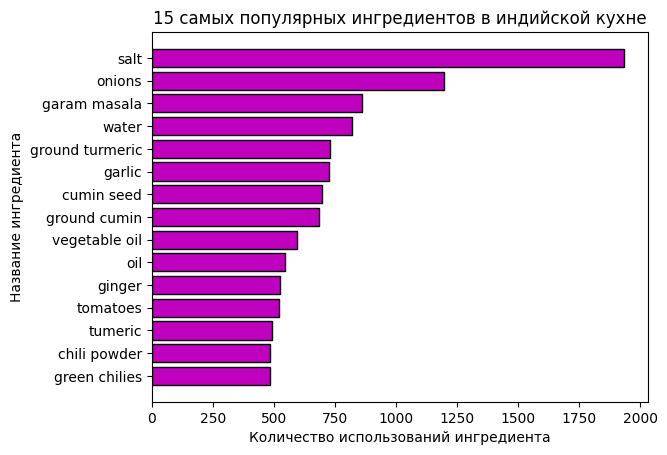

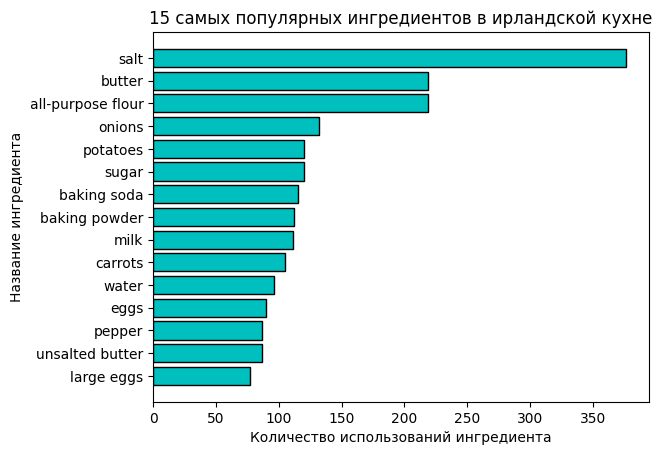

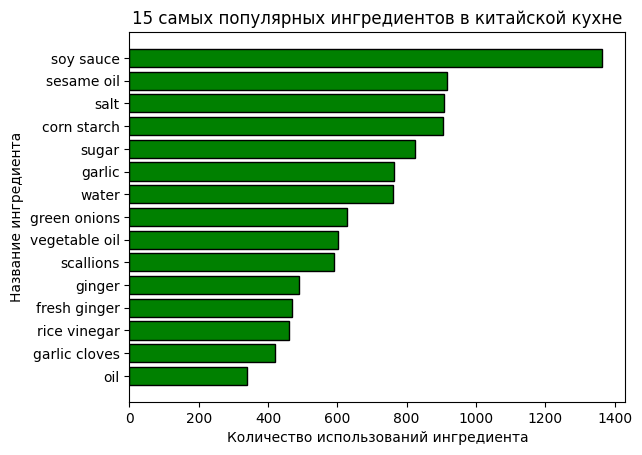

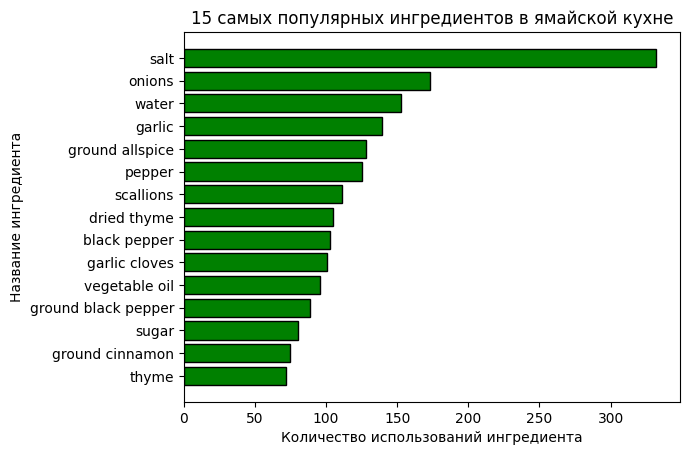

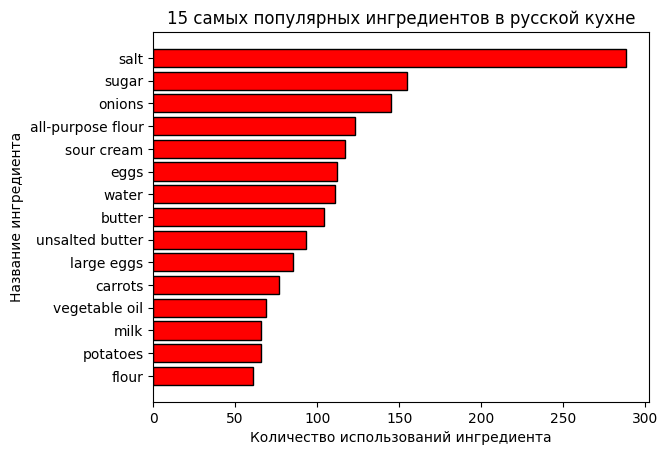

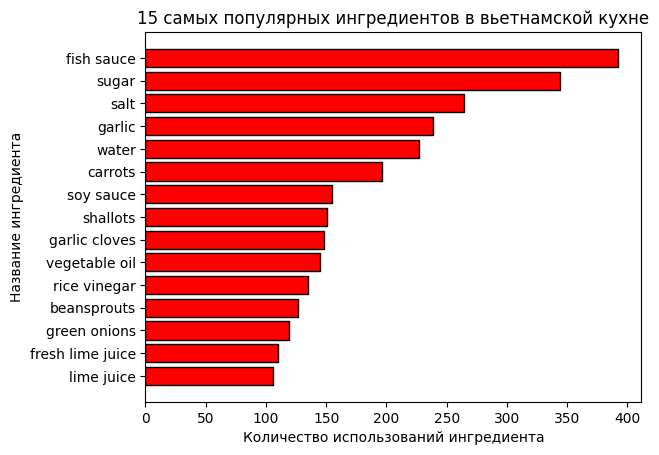

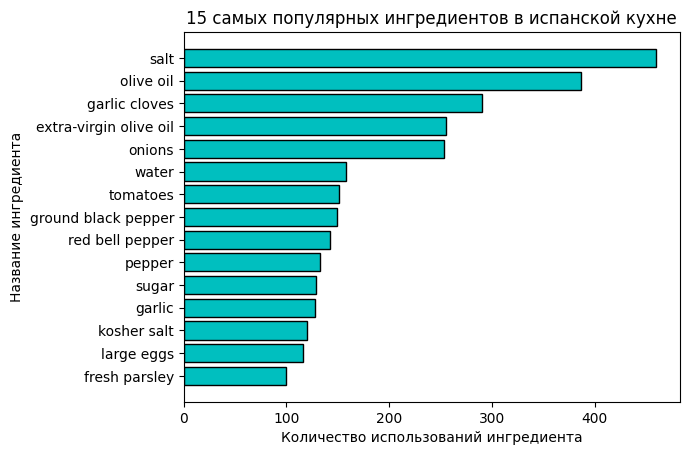

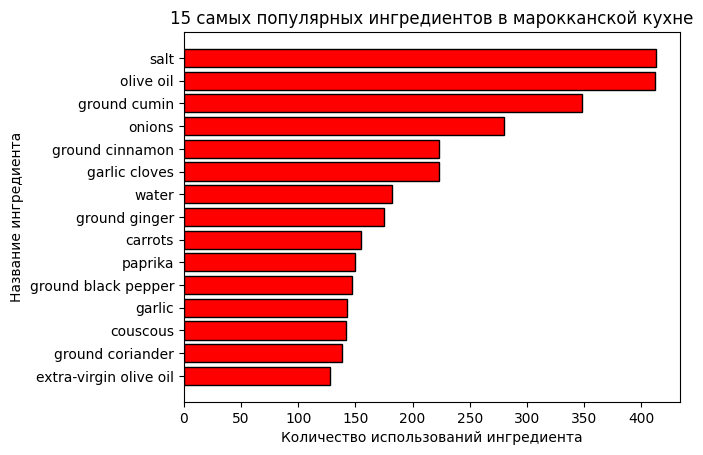

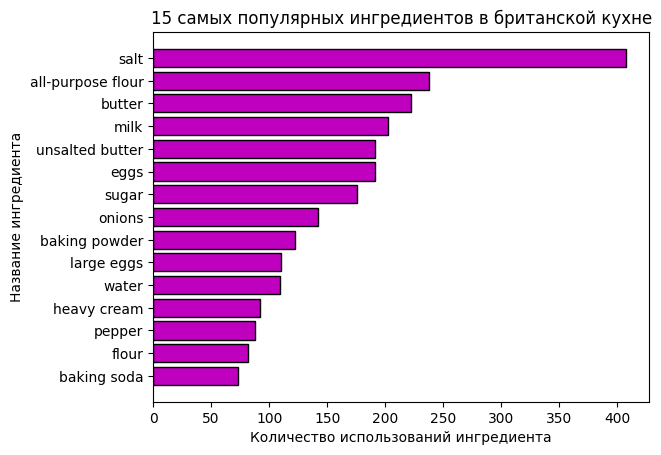

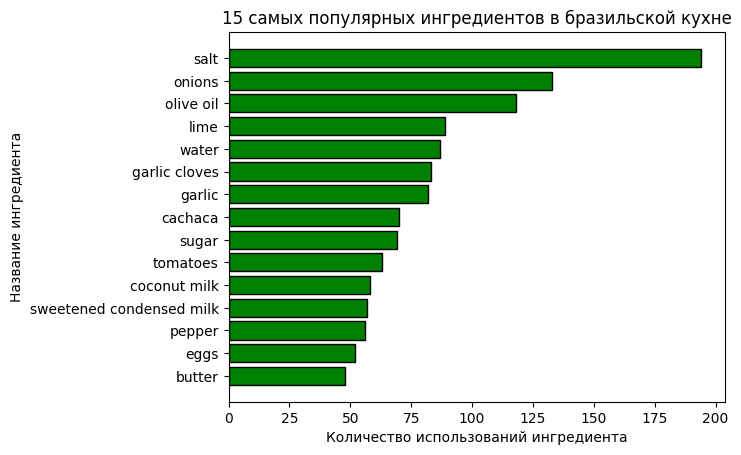

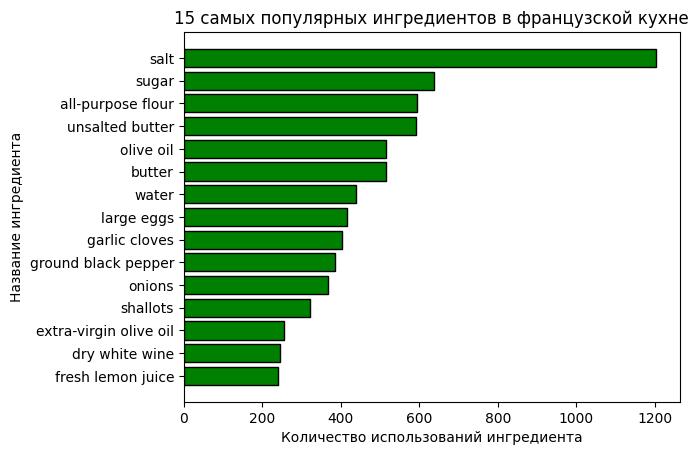

In [94]:
cuisine_names = list(df['cuisine'].unique())
shuffle(cuisine_names)
for cuisine_name in cuisine_names:
    plot_most_popular_ingredients_barh(df, cuisine_name)

## Подготовка к обучению

Отдельно запишем признаки

In [95]:
features = df.drop('cuisine').to_numpy()
features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

И таргет

In [96]:
target = df['cuisine'].to_numpy()
target

array(['greek', 'southern_us', 'filipino', ..., 'irish', 'chinese',
       'mexican'], dtype=object)

In [97]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3, stratify=target, random_state=42)

$\textbf{ВАЖНО!!!}$\
Указать параметр ```stratify = target```,потому что распределение таргета отличается от равномерного.\
Существует вероятность, что некоторые малочисленные классы не попадут в train выборку $\rightarrow$ модель не обучится на них $\rightarrow$ качество на test выборке упадёт.

In [98]:
np.unique(y_train, return_counts= True)

(array(['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino',
        'french', 'greek', 'indian', 'irish', 'italian', 'jamaican',
        'japanese', 'korean', 'mexican', 'moroccan', 'russian',
        'southern_us', 'spanish', 'thai', 'vietnamese'], dtype=object),
 array([ 327,  563, 1082, 1871,  529, 1852,  823, 2102,  467, 5486,  368,
         996,  581, 4506,  575,  342, 3024,  692, 1077,  578], dtype=int64))

In [99]:
np.unique(y_test, return_counts= True)

(array(['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino',
        'french', 'greek', 'indian', 'irish', 'italian', 'jamaican',
        'japanese', 'korean', 'mexican', 'moroccan', 'russian',
        'southern_us', 'spanish', 'thai', 'vietnamese'], dtype=object),
 array([ 140,  241,  464,  802,  226,  794,  352,  901,  200, 2352,  158,
         427,  249, 1932,  246,  147, 1296,  297,  462,  247], dtype=int64))

## Обучение моделей.

### KNN

Первым делом, используем метод $KNN$ - k ближайших соседей.\
k - гиперпараметр, который будем подбирать по сетке.

In [24]:
knn = KNeighborsClassifier(n_jobs=-1)
knn_grid_search = GridSearchCV(knn, param_grid={'n_neighbors': [20, 40, 60, 80]}, scoring='accuracy', cv=3)
knn_grid_search.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(n_jobs=-1),
             param_grid={'n_neighbors': [20, 40, 60, 80]}, scoring='accuracy')

In [25]:
knn_grid_search.best_params_

{'n_neighbors': 20}

In [26]:
knn = knn_grid_search.best_estimator_

In [27]:
knn

KNeighborsClassifier(n_jobs=-1, n_neighbors=20)

In [28]:
pred = knn.predict(x_test)

In [29]:
accuracy_score(y_test, pred)

0.5039805581161485

KNN дал результат accuracy_score = 0.5

Построим матрицу путанницы

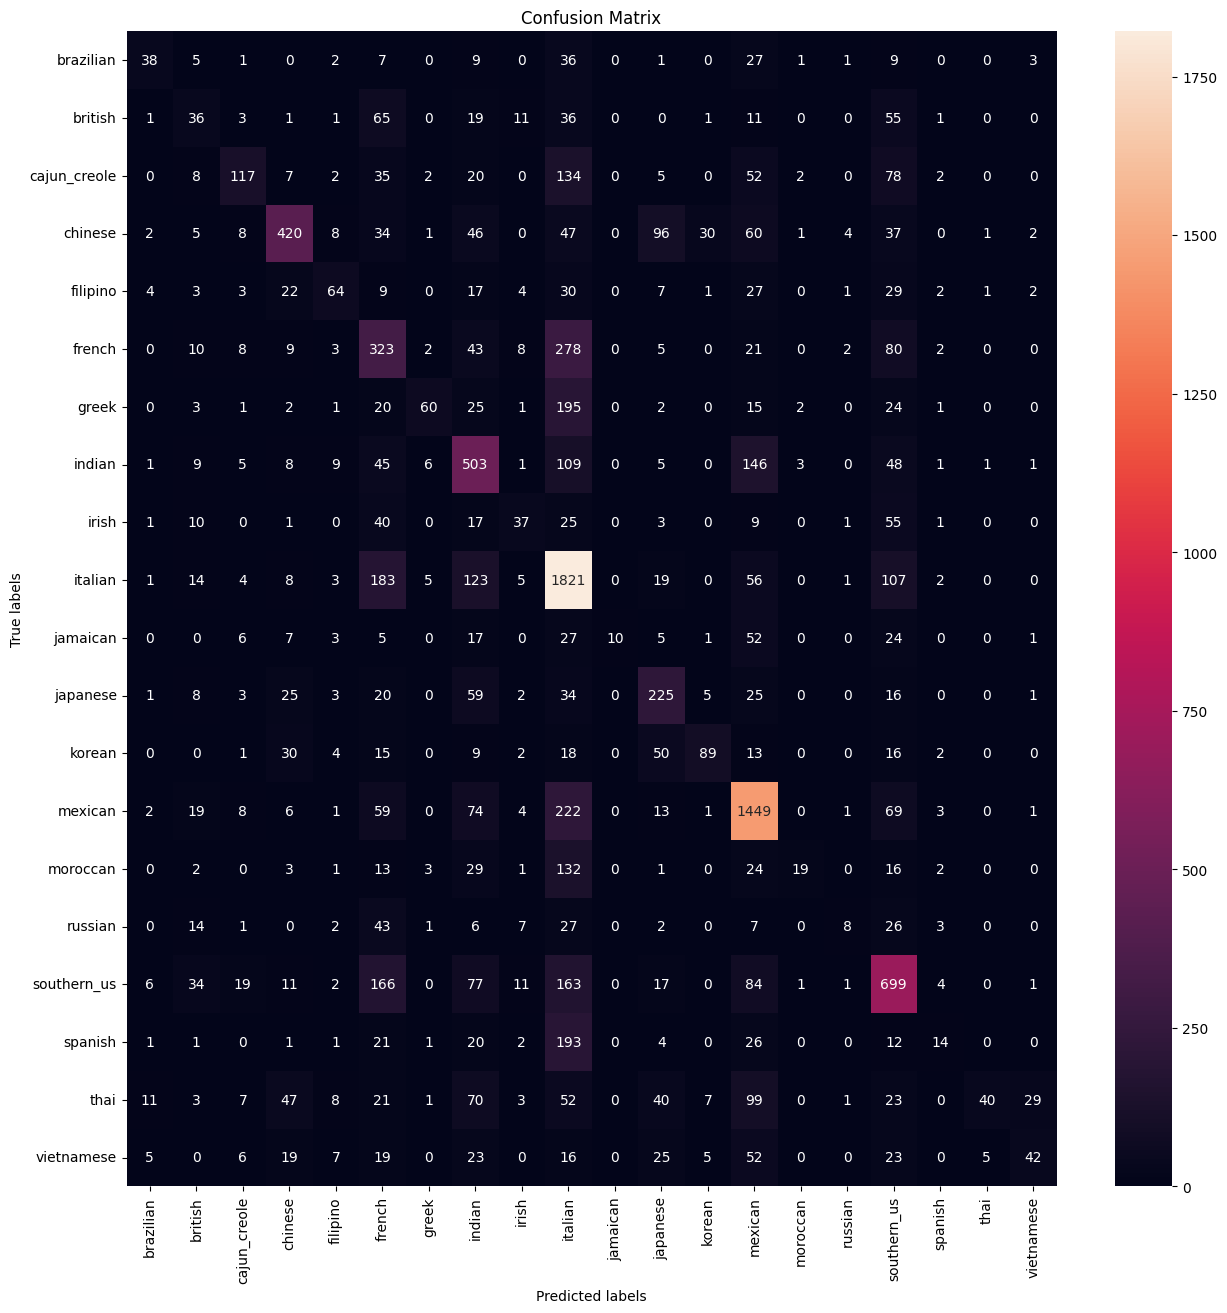

In [38]:
labels = np.unique(target)
cm = confusion_matrix(y_test, pred, labels=labels)

plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Random Forest

Построим random forest

In [56]:
random_forest_clf = RandomForestClassifier(n_estimators=1250, max_depth=75, n_jobs=-1)
random_forest_clf.fit(x_train, y_train)

RandomForestClassifier(max_depth=75, n_estimators=1250, n_jobs=-1)

In [57]:
pred = random_forest_clf.predict(x_test)
accuracy_score(y_test, pred)

0.6727562222408447

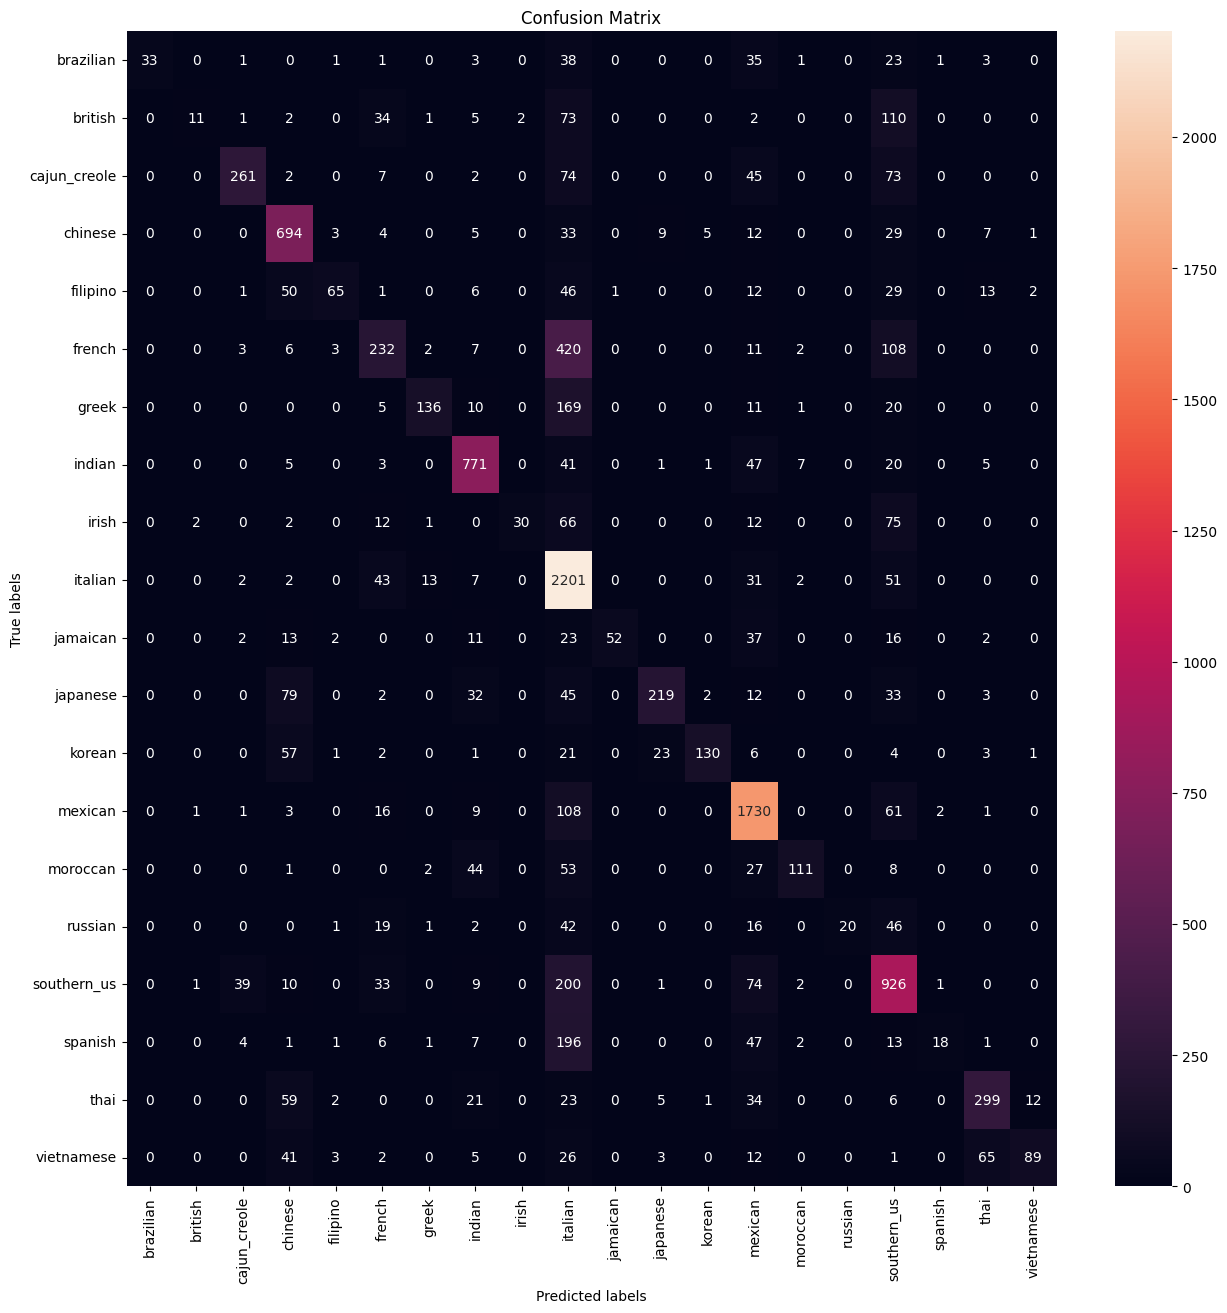

In [58]:
labels = np.unique(target)
cm = confusion_matrix(y_test, pred, labels=labels)

plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Gradient boosting

In [70]:
cat_boost_clf = CatBoostClassifier(iterations=250,
                                   max_depth=7,
                                   task_type="GPU",
                                   devices='0')
cat_boost_clf.fit(x_train, y_train)

Learning rate set to 0.40599
0:	learn: 2.3262072	total: 271ms	remaining: 1m 7s
1:	learn: 2.1083268	total: 326ms	remaining: 40.4s
2:	learn: 1.9931155	total: 369ms	remaining: 30.4s
3:	learn: 1.9017337	total: 424ms	remaining: 26.1s
4:	learn: 1.8470198	total: 466ms	remaining: 22.8s
5:	learn: 1.7803948	total: 529ms	remaining: 21.5s
6:	learn: 1.7430721	total: 564ms	remaining: 19.6s
7:	learn: 1.7040203	total: 602ms	remaining: 18.2s
8:	learn: 1.6614967	total: 639ms	remaining: 17.1s
9:	learn: 1.6412590	total: 670ms	remaining: 16.1s
10:	learn: 1.6131515	total: 710ms	remaining: 15.4s
11:	learn: 1.5909285	total: 748ms	remaining: 14.8s
12:	learn: 1.5643137	total: 790ms	remaining: 14.4s
13:	learn: 1.5487157	total: 825ms	remaining: 13.9s
14:	learn: 1.5292542	total: 859ms	remaining: 13.5s
15:	learn: 1.5070454	total: 904ms	remaining: 13.2s
16:	learn: 1.4899325	total: 939ms	remaining: 12.9s
17:	learn: 1.4638707	total: 989ms	remaining: 12.7s
18:	learn: 1.4383366	total: 1.05s	remaining: 12.8s
19:	learn: 1

161:	learn: 0.9009658	total: 6.03s	remaining: 3.27s
162:	learn: 0.9006949	total: 6.06s	remaining: 3.23s
163:	learn: 0.9004944	total: 6.09s	remaining: 3.19s
164:	learn: 0.8995490	total: 6.12s	remaining: 3.15s
165:	learn: 0.8988036	total: 6.15s	remaining: 3.11s
166:	learn: 0.8967213	total: 6.19s	remaining: 3.07s
167:	learn: 0.8961187	total: 6.22s	remaining: 3.03s
168:	learn: 0.8945164	total: 6.25s	remaining: 3s
169:	learn: 0.8934821	total: 6.29s	remaining: 2.96s
170:	learn: 0.8928745	total: 6.32s	remaining: 2.92s
171:	learn: 0.8909268	total: 6.36s	remaining: 2.88s
172:	learn: 0.8899270	total: 6.39s	remaining: 2.85s
173:	learn: 0.8896182	total: 6.42s	remaining: 2.81s
174:	learn: 0.8890950	total: 6.46s	remaining: 2.77s
175:	learn: 0.8869153	total: 6.5s	remaining: 2.73s
176:	learn: 0.8863982	total: 6.53s	remaining: 2.69s
177:	learn: 0.8851798	total: 6.56s	remaining: 2.65s
178:	learn: 0.8836212	total: 6.6s	remaining: 2.62s
179:	learn: 0.8831826	total: 6.63s	remaining: 2.58s
180:	learn: 0.880

In [71]:
pred = cat_boost_clf.predict(x_test)
accuracy_score(y_test, pred)

0.7239587697980391

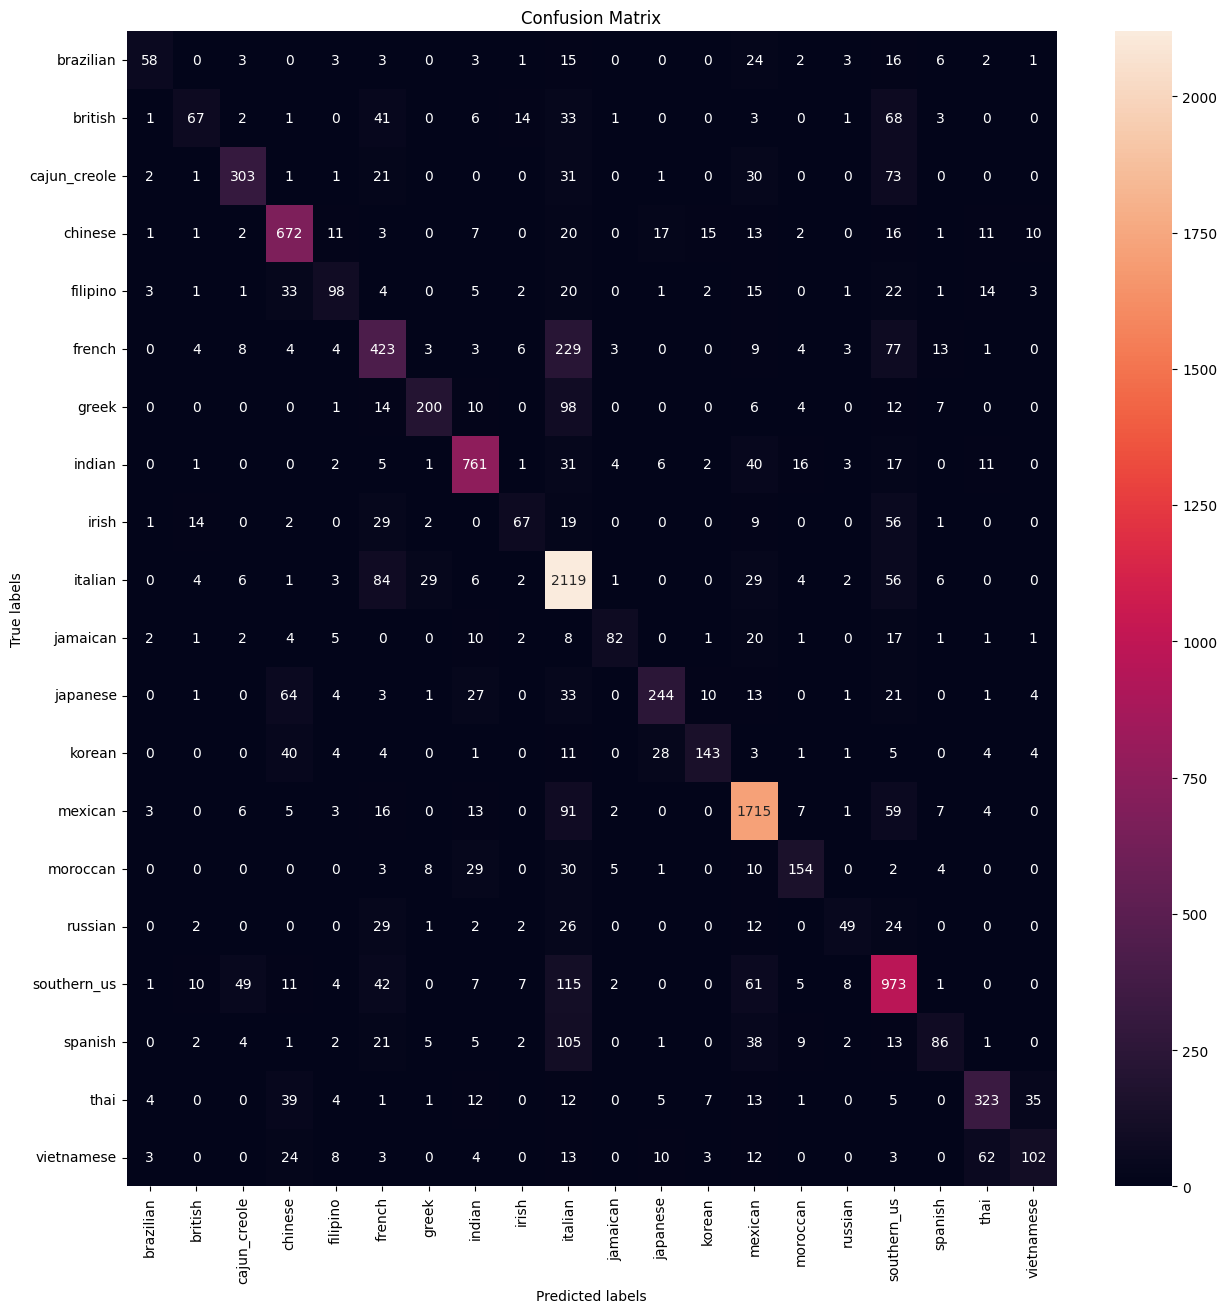

In [72]:
labels = np.unique(target)
cm = confusion_matrix(y_test, pred, labels=labels)

plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Логистическая регрессия

In [74]:
logistic_reg = LogisticRegression(n_jobs=-1, solver='lbfgs')
logistic_reg.fit(x_train, y_train)

LogisticRegression(n_jobs=-1)

In [75]:
pred = logistic_reg.predict(x_test)
accuracy_score(y_test, pred)

0.771725467191821

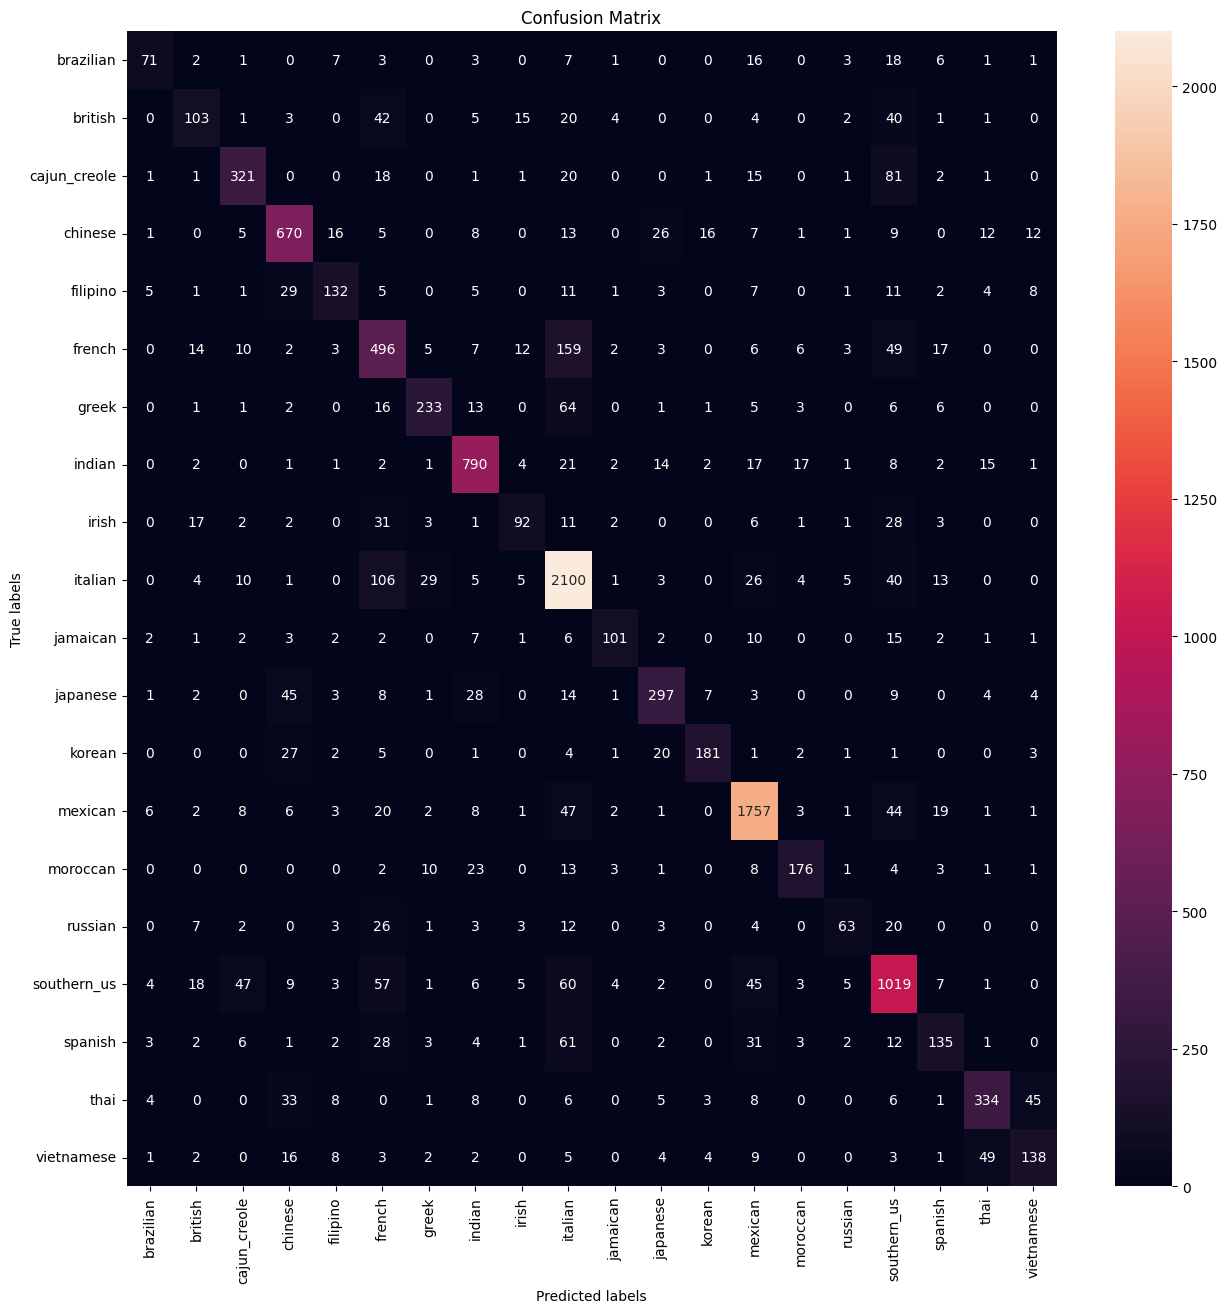

In [76]:
labels = np.unique(target)
cm = confusion_matrix(y_test, pred, labels=labels)

plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Заключение

Были обучены 4 модели
1) KNN: accuracy $\approx$ 0.5
2) Random forest: accuracy $\approx$ 0.67
3) Gradient boosting: accuracy $\approx$ 0.72
4) Logistic regression: accuracy $\approx$ 0.77
Лучший результат был получен с помощью $\textbf{Logistic regression}$, худший с помощью $\textbf{KNN}$.